In [17]:
import numpy as np
import pandas as pd
from scipy.special import expit 
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8" 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from scipy.special import softmax
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

In [18]:
df = pd.read_csv(r"MergedData.csv")
print("Shape:", df.shape)
df = df.drop(columns=["Unnamed: 0"])
df.head()

Shape: (11000, 285)


Rating  Binary Rating  Current Ratio  Long-term Debt / Capital  \
0       A              1         1.1507                    0.4551   
1  AAA-AA              1         1.1129                    0.0072   
2     BBB              1         1.9276                    0.2924   
3  AAA-AA              1         0.8358                    0.4708   
4       A              1         1.2931                    0.2644   

   Debt/Equity Ratio  Gross Margin  Operating Margin  EBIT Margin  \
0             0.8847       77.6230           19.4839      19.4839   
1             0.0073       43.6619           19.8327      19.8327   
2             0.4255       11.9008            3.3173       3.3173   
3             0.9491       64.5096           18.4549      18.4549   
4             0.4036        3.8385            1.3269       1.3269   

   EBITDA Margin  Pre-Tax Profit Margin  ...  Rating_Year_2014  \
0        28.9834                13.6093  ...                 0   
1        23.9379                20.8699  ...                 0   
2         3.6338                 3.0536  ...                 0   
3        27.9377                15.1135  ...                 0   
4         1.5847                 1.2304  ...                 0   

   Rating_Year_2015  Rating_Year_2016  Rating Agency_DBRS  \
0                 0                 0                   0   
1                 0                 0                   0   
2                 0                 0                   0   
3                 0                 0                   0   
4                 0                 0                   0   

   Rating Agency_Egan-Jones Ratings Company  Rating Agency_Fitch Ratings  \
0                                         0                            0   
1                                         0                            0   
2                                         0                            0   
3                                         0                            0   
4                                         0                            0   

   Rating Agency_HR Ratings de Mexico S.A. de C.V.  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Rating Agency_Japan Credit Rating Agency,Ltd.  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Rating Agency_Moody's Investors Service  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   Rating Agency_Standard & Poor's Ratings Services  
0                                                 1  
1                                                 1  
2                                                 1  
3                                                 1  
4                                                 1  

[5 rows x 284 columns]

In [19]:
import numpy as np
import pandas as pd
from scipy.special import expit, softmax
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split


# -------------------------------------------------------
# 1. Prepare data (same as your code)
# -------------------------------------------------------
X = df.drop(columns=["Rating", "Binary Rating"])
y_rating = df["Rating"]

le = LabelEncoder()
y_r = le.fit_transform(y_rating)
n_classes = len(le.classes_)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_r, test_size=0.2, random_state=42
)

n_train, n_features = X_train.shape

In [20]:
#  log posterior 
def log_posterior_multiclass(B, X, y, n_classes):
    """
    B: flattened parameter vector of shape (n_features * (n_classes-1),)
    """
    n_samples, n_features = X.shape
    B = B.reshape((n_features, n_classes - 1))
    
    # Compute linear scores for each class (K-1), last class is reference
    scores = X @ B
    scores = np.hstack([scores, np.zeros((n_samples, 1))])  # add baseline (class K)
    
    probs = softmax(scores, axis=1)
    
    # Log-likelihood
    log_likelihood = np.sum(np.log(probs[np.arange(n_samples), y] + 1e-10))
    
    # Gaussian prior N(0, σ²=10)
    log_prior = -0.5 * np.sum(B**2 / 10)
    
    return log_likelihood + log_prior

In [21]:
# Metropolis–Hastings Sampler
def metropolis_multiclass(X, y, n_classes, n_iters=20000, proposal_std=0.02):
    n_features = X.shape[1]
    B = np.zeros((n_features, n_classes - 1))
    samples = []
    accepted = 0

    current_log_post = log_posterior_multiclass(B.ravel(), X, y, n_classes)

    for i in range(n_iters):
        # Propose new B
        B_new = B + np.random.normal(0, proposal_std, size=B.shape)
        new_log_post = log_posterior_multiclass(B_new.ravel(), X, y, n_classes)

        # Accept/reject
        accept_prob = np.exp(new_log_post - current_log_post)
        if np.random.rand() < accept_prob:
            B = B_new
            current_log_post = new_log_post
            accepted += 1
        
        samples.append(B.ravel())

    samples = np.array(samples)
    acceptance_rate = accepted / n_iters
    print(f"Acceptance Rate: {acceptance_rate:.3f}")
    return samples

In [22]:
samples_multi = metropolis_multiclass(
    X_train, y_train, n_classes, n_iters=20000, proposal_std=0.001
)

burn_in = 2000
B_mean = samples_multi[burn_in:].mean(axis=0).reshape((X_train.shape[1], n_classes - 1))

Acceptance Rate: 0.598


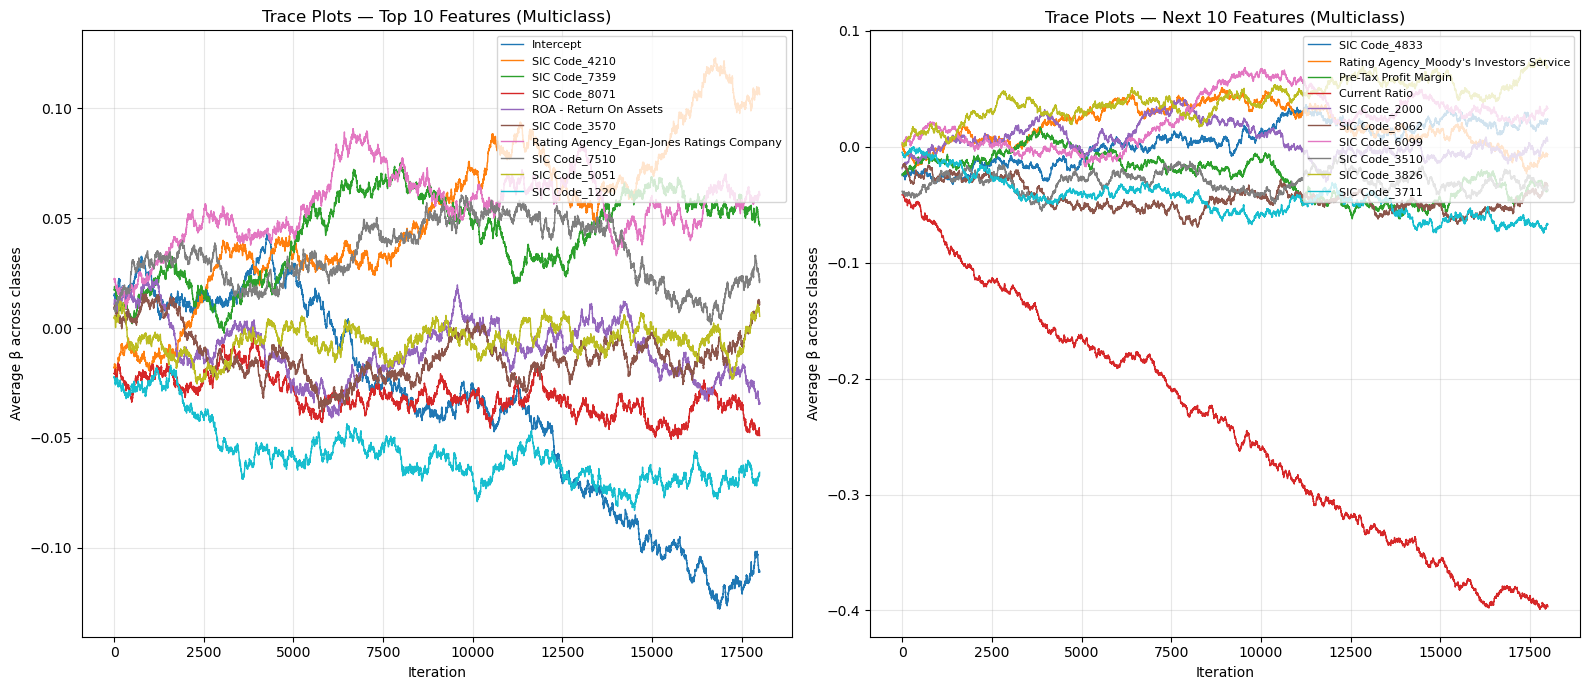

In [23]:
feature_names = ["Intercept"] + list(df.drop(columns=["Rating", "Binary Rating"]).columns)
# Compute mean coefficient magnitude across classes
abs_B = np.abs(B_mean).mean(axis=1)
top20_indices = np.argsort(abs_B)[-20:][::-1]
top20_features = [feature_names[i] for i in top20_indices]

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Split top 20 into 10 + 10
first10 = top20_indices[:10]
second10 = top20_indices[10:]

# --- Left Panel ---
for idx in first10:
    # show trace for average of all class coefficients for that feature
    coeff_trace = samples_multi[burn_in:, idx::X_train.shape[1]].mean(axis=1)
    axes[0].plot(coeff_trace, label=feature_names[idx], linewidth=1)
axes[0].set_title("Trace Plots — Top 10 Features (Multiclass)")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Average β across classes")
axes[0].legend(fontsize=8, loc="upper right")
axes[0].grid(alpha=0.3)

# --- Right Panel ---
for idx in second10:
    coeff_trace = samples_multi[burn_in:, idx::X_train.shape[1]].mean(axis=1)
    axes[1].plot(coeff_trace, label=feature_names[idx], linewidth=1)
axes[1].set_title("Trace Plots — Next 10 Features (Multiclass)")
axes[1].set_xlabel("Iteration")
axes[1].set_ylabel("Average β across classes")
axes[1].legend(fontsize=8, loc="upper right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    r2_score,
    roc_auc_score
)

# Predictions
def predict_multiclass(X, B_mean, n_classes):
    scores = X @ B_mean
    scores = np.hstack([scores, np.zeros((X.shape[0], 1))])  # baseline class
    probs = softmax(scores, axis=1)
    return np.argmax(probs, axis=1), probs

# Predictions
y_pred_train, _ = predict_multiclass(X_train, B_mean, n_classes)
y_pred_test, y_prob_test = predict_multiclass(X_test, B_mean, n_classes)

# Evaluation on Test Set
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, average='macro')
rec = recall_score(y_test, y_pred_test, average='macro')
f1 = f1_score(y_test, y_pred_test, average='macro')

print("\nMultinomial Metropolis Logistic Regression Results")
print(f"Overall Test Accuracy : {acc:.4f}")
print(f"Overall Precision     : {prec:.4f}")
print(f"Overall Recall        : {rec:.4f}")
print(f"Overall F1 Score      : {f1:.4f}")

print("\nPer-Class Metrics")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))

print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred_test))

# Evaluate Correct vs Incorrect (Binary Interpretation)
correct_vs_incorrect = (y_pred_test == y_test).astype(int)
acc_bin = correct_vs_incorrect.mean()
prec_bin = precision_score(correct_vs_incorrect, np.ones_like(correct_vs_incorrect), zero_division=0)
rec_bin = recall_score(correct_vs_incorrect, np.ones_like(correct_vs_incorrect), zero_division=0)
f1_bin = f1_score(correct_vs_incorrect, np.ones_like(correct_vs_incorrect), zero_division=0)

print("Correct vs Incorrect (Binary Evaluation)")
print(f"Accuracy:  {acc_bin:.4f}")
print(f"Precision: {prec_bin:.4f}")
print(f"Recall:    {rec_bin:.4f}")
print(f"F1 Score:  {f1_bin:.4f}")


Multinomial Metropolis Logistic Regression Results
Overall Test Accuracy : 0.4764
Overall Precision     : 0.4675
Overall Recall        : 0.4568
Overall F1 Score      : 0.4568

Per-Class Metrics
              precision    recall  f1-score   support

           A       0.45      0.62      0.52       561
      AAA-AA       0.44      0.34      0.38       171
 B and Below       0.53      0.57      0.55       357
          BB       0.39      0.32      0.35       405
         BBB       0.53      0.44      0.48       706

    accuracy                           0.48      2200
   macro avg       0.47      0.46      0.46      2200
weighted avg       0.48      0.48      0.47      2200

Confusion Matrix
[[347  27  29  37 121]
 [ 66  58   1  14  32]
 [ 50  11 202  59  35]
 [ 90   8  89 129  89]
 [212  29  62  91 312]]
Correct vs Incorrect (Binary Evaluation)
Accuracy:  0.4764
Precision: 0.4764
Recall:    1.0000
F1 Score:  0.6453


In [25]:
# Create a DataFrame of ACTUAL, PRED, and PROBS

# Convert encoded labels back to original Rating names
actual_classes = le.inverse_transform(y_test)
pred_classes   = le.inverse_transform(y_pred_test)

# Build probability column names
prob_cols = [f"prob_{cls}" for cls in le.classes_]

# Create dataframe
result_df = pd.DataFrame({
    "actual": actual_classes,
    "pred": pred_classes,
})

# Add probability columns (probs are in y_prob_test)
for i, cls in enumerate(le.classes_):
    result_df[f"prob_{cls}"] = y_prob_test[:, i]

In [26]:
# ---------- 1. Prepare posterior samples ----------
posterior_samples_multi = samples_multi[burn_in:]       # shape: (S, n_features*(K-1))
S = posterior_samples_multi.shape[0]
n_test = X_test.shape[0]
n_features = X_test.shape[1]
n_classes = len(le.classes_)

# ---------- 2. Compute posterior predictive samples ----------
posterior_probs_test = []

for s in range(S):
    B_s = posterior_samples_multi[s].reshape(n_features, n_classes - 1)
    scores = X_test @ B_s
    scores = np.hstack([scores, np.zeros((n_test, 1))])   # reference (Kth) class
    probs_s = softmax(scores, axis=1)
    posterior_probs_test.append(probs_s)

posterior_probs_test = np.array(posterior_probs_test)
# final shape: (S, n_test, n_classes)

# ---------- 3. Compute 95% credible intervals ----------
lower_ci = np.percentile(posterior_probs_test, 2.5, axis=0)
upper_ci = np.percentile(posterior_probs_test, 97.5, axis=0)

# ---------- 4. Add intervals to result_df ----------
for i, cls in enumerate(le.classes_):
    result_df[f"CI_lower_{cls}"] = lower_ci[:, i]
    result_df[f"CI_upper_{cls}"] = upper_ci[:, i]

# show results
display(result_df.head(5))


actual         pred    prob_A  prob_AAA-AA  prob_B and Below  \
0  B and Below  B and Below  0.173657     0.053388          0.298799   
1           BB           BB  0.181225     0.144894          0.097036   
2          BBB  B and Below  0.201688     0.091858          0.406035   
3            A  B and Below  0.238503     0.082824          0.285869   
4  B and Below  B and Below  0.012593     0.013593          0.543298   

    prob_BB  prob_BBB  CI_lower_A  CI_upper_A  CI_lower_AAA-AA  \
0  0.237654  0.236501    0.126326    0.219836         0.031648   
1  0.296747  0.280098    0.117288    0.240535         0.058144   
2  0.062215  0.238204    0.117678    0.268614         0.054980   
3  0.144992  0.247813    0.063667    0.453978         0.025128   
4  0.350144  0.080371    0.000377    0.119425         0.000758   

   CI_upper_AAA-AA  CI_lower_B and Below  CI_upper_B and Below  CI_lower_BB  \
0         0.101570              0.220127              0.352306     0.162753   
1         0.267979              0.042235              0.170711     0.207800   
2         0.147370              0.279214              0.477191     0.021920   
3         0.235702              0.096343              0.536001     0.060338   
4         0.053172              0.234016              0.814749     0.124704   

   CI_upper_BB  CI_lower_BBB  CI_upper_BBB  
0     0.319264      0.160346      0.332432  
1     0.438914      0.190158      0.387400  
2     0.131877      0.155803      0.347965  
3     0.229010      0.159983      0.310532  
4     0.649075      0.009455      0.197177

## Original Data

Accuracy:  0.5452<br>
Precision: 0.5452<br>
Recall:    1.0000<br>
F1 Score:  0.7056<br>


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>actual</th>
      <th>pred</th>
      <th>prob_A</th>
      <th>prob_AAA-AA</th>
      <th>prob_B and Below</th>
      <th>prob_BB</th>
      <th>prob_BBB</th>
      <th>CI_lower_A</th>
      <th>CI_upper_A</th>
      <th>CI_lower_AAA-AA</th>
      <th>CI_upper_AAA-AA</th>
      <th>CI_lower_B and Below</th>
      <th>CI_upper_B and Below</th>
      <th>CI_lower_BB</th>
      <th>CI_upper_BB</th>
      <th>CI_lower_BBB</th>
      <th>CI_upper_BBB</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.428282</td>
      <td>0.097541</td>
      <td>0.050389</td>
      <td>0.147821</td>
      <td>0.275966</td>
      <td>0.333543</td>
      <td>0.553926</td>
      <td>0.066953</td>
      <td>0.144587</td>
      <td>0.030624</td>
      <td>0.097140</td>
      <td>0.100191</td>
      <td>0.206934</td>
      <td>0.216842</td>
      <td>0.377662</td>
    </tr>
    <tr>
      <th>1</th>
      <td>B and Below</td>
      <td>B and Below</td>
      <td>0.018659</td>
      <td>0.023490</td>
      <td>0.481271</td>
      <td>0.330929</td>
      <td>0.145652</td>
      <td>0.004571</td>
      <td>0.083937</td>
      <td>0.005597</td>
      <td>0.080679</td>
      <td>0.341600</td>
      <td>0.586884</td>
      <td>0.186930</td>
      <td>0.523313</td>
      <td>0.062762</td>
      <td>0.223496</td>
    </tr>
    <tr>
      <th>2</th>
      <td>A</td>
      <td>A</td>
      <td>0.579795</td>
      <td>0.183727</td>
      <td>0.027879</td>
      <td>0.040547</td>
      <td>0.168051</td>
      <td>0.437017</td>
      <td>0.708360</td>
      <td>0.114568</td>
      <td>0.261799</td>
      <td>0.016203</td>
      <td>0.051013</td>
      <td>0.014575</td>
      <td>0.126959</td>
      <td>0.105453</td>
      <td>0.272800</td>
    </tr>
    <tr>
      <th>3</th>
      <td>B and Below</td>
      <td>B and Below</td>
      <td>0.113267</td>
      <td>0.098893</td>
      <td>0.522622</td>
      <td>0.114479</td>
      <td>0.150739</td>
      <td>0.026225</td>
      <td>0.283242</td>
      <td>0.023012</td>
      <td>0.306971</td>
      <td>0.166018</td>
      <td>0.787266</td>
      <td>0.045774</td>
      <td>0.246617</td>
      <td>0.038566</td>
      <td>0.272347</td>
    </tr>
    <tr>
      <th>4</th>
      <td>BBB</td>
      <td>BBB</td>
      <td>0.177281</td>
      <td>0.010913</td>
      <td>0.033193</td>
      <td>0.374262</td>
      <td>0.404351</td>
      <td>0.029519</td>
      <td>0.494718</td>
      <td>0.001114</td>
      <td>0.129215</td>
      <td>0.001985</td>
      <td>0.180461</td>
      <td>0.125835</td>
      <td>0.611617</td>
      <td>0.119353</td>
      <td>0.678570</td>
    </tr>
    <tr>
      <th>5</th>
      <td>A</td>
      <td>A</td>
      <td>0.440053</td>
      <td>0.091994</td>
      <td>0.095049</td>
      <td>0.084686</td>
      <td>0.288218</td>
      <td>0.240295</td>
      <td>0.538558</td>
      <td>0.052982</td>
      <td>0.219449</td>
      <td>0.056285</td>
      <td>0.148975</td>
      <td>0.048037</td>
      <td>0.204397</td>
      <td>0.206661</td>
      <td>0.374241</td>
    </tr>
    <tr>
      <th>6</th>
      <td>BB</td>
      <td>BBB</td>
      <td>0.053961</td>
      <td>0.037082</td>
      <td>0.291921</td>
      <td>0.277021</td>
      <td>0.340015</td>
      <td>0.034980</td>
      <td>0.089116</td>
      <td>0.011244</td>
      <td>0.083266</td>
      <td>0.189606</td>
      <td>0.398213</td>
      <td>0.161915</td>
      <td>0.366872</td>
      <td>0.177917</td>
      <td>0.441448</td>
    </tr>
    <tr>
      <th>7</th>
      <td>B and Below</td>
      <td>B and Below</td>
      <td>0.028401</td>
      <td>0.040922</td>
      <td>0.608571</td>
      <td>0.228841</td>
      <td>0.093264</td>
      <td>0.011500</td>
      <td>0.106114</td>
      <td>0.006714</td>
      <td>0.213623</td>
      <td>0.315983</td>
      <td>0.733209</td>
      <td>0.120371</td>
      <td>0.318342</td>
      <td>0.041877</td>
      <td>0.169408</td>
    </tr>
    <tr>
      <th>8</th>
      <td>AAA-AA</td>
      <td>AAA-AA</td>
      <td>0.174599</td>
      <td>0.312487</td>
      <td>0.131080</td>
      <td>0.074252</td>
      <td>0.307581</td>
      <td>0.095292</td>
      <td>0.261344</td>
      <td>0.181514</td>
      <td>0.468624</td>
      <td>0.080546</td>
      <td>0.241676</td>
      <td>0.020641</td>
      <td>0.303287</td>
      <td>0.204774</td>
      <td>0.393852</td>
    </tr>
    <tr>
      <th>9</th>
      <td>BBB</td>
      <td>AAA-AA</td>
      <td>0.151960</td>
      <td>0.305695</td>
      <td>0.185075</td>
      <td>0.057759</td>
      <td>0.299511</td>
      <td>0.088844</td>
      <td>0.241707</td>
      <td>0.149742</td>
      <td>0.421190</td>
      <td>0.120067</td>
      <td>0.260370</td>
      <td>0.028455</td>
      <td>0.162491</td>
      <td>0.195630</td>
      <td>0.459014</td>
    </tr>
    <tr>
      <th>10</th>
      <td>A</td>
      <td>A</td>
      <td>0.641515</td>
      <td>0.120834</td>
      <td>0.029599</td>
      <td>0.038281</td>
      <td>0.169770</td>
      <td>0.364721</td>
      <td>0.753312</td>
      <td>0.073959</td>
      <td>0.224752</td>
      <td>0.013392</td>
      <td>0.078123</td>
      <td>0.016559</td>
      <td>0.141467</td>
      <td>0.133039</td>
      <td>0.194106</td>
    </tr>
    <tr>
      <th>11</th>
      <td>BBB</td>
      <td>BBB</td>
      <td>0.156490</td>
      <td>0.063031</td>
      <td>0.215838</td>
      <td>0.267951</td>
      <td>0.296691</td>
      <td>0.117864</td>
      <td>0.218093</td>
      <td>0.031897</td>
      <td>0.124038</td>
      <td>0.138647</td>
      <td>0.299573</td>
      <td>0.190770</td>
      <td>0.333426</td>
      <td>0.229982</td>
      <td>0.364183</td>
    </tr>
    <tr>
      <th>12</th>
      <td>A</td>
      <td>A</td>
      <td>0.394309</td>
      <td>0.166054</td>
      <td>0.043314</td>
      <td>0.127037</td>
      <td>0.269285</td>
      <td>0.262880</td>
      <td>0.516272</td>
      <td>0.102728</td>
      <td>0.287645</td>
      <td>0.021978</td>
      <td>0.082155</td>
      <td>0.066513</td>
      <td>0.199137</td>
      <td>0.191068</td>
      <td>0.351623</td>
    </tr>
    <tr>
      <th>13</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.462116</td>
      <td>0.112061</td>
      <td>0.074035</td>
      <td>0.059812</td>
      <td>0.291977</td>
      <td>0.263493</td>
      <td>0.558267</td>
      <td>0.060794</td>
      <td>0.205399</td>
      <td>0.042093</td>
      <td>0.127043</td>
      <td>0.033709</td>
      <td>0.176942</td>
      <td>0.224457</td>
      <td>0.356709</td>
    </tr>
    <tr>
      <th>14</th>
      <td>A</td>
      <td>A</td>
      <td>0.670173</td>
      <td>0.119468</td>
      <td>0.027046</td>
      <td>0.031791</td>
      <td>0.151522</td>
      <td>0.386160</td>
      <td>0.750793</td>
      <td>0.071201</td>
      <td>0.194890</td>
      <td>0.012471</td>
      <td>0.080236</td>
      <td>0.014344</td>
      <td>0.143840</td>
      <td>0.120593</td>
      <td>0.191799</td>
    </tr>
    <tr>
      <th>15</th>
      <td>BB</td>
      <td>B and Below</td>
      <td>0.165182</td>
      <td>0.130997</td>
      <td>0.417044</td>
      <td>0.204844</td>
      <td>0.081933</td>
      <td>0.081496</td>
      <td>0.360058</td>
      <td>0.063418</td>
      <td>0.209049</td>
      <td>0.197792</td>
      <td>0.619647</td>
      <td>0.081903</td>
      <td>0.383401</td>
      <td>0.033045</td>
      <td>0.163567</td>
    </tr>
    <tr>
      <th>16</th>
      <td>BB</td>
      <td>BB</td>
      <td>0.240048</td>
      <td>0.121627</td>
      <td>0.086075</td>
      <td>0.277656</td>
      <td>0.274594</td>
      <td>0.142055</td>
      <td>0.299192</td>
      <td>0.068204</td>
      <td>0.218697</td>
      <td>0.051794</td>
      <td>0.150890</td>
      <td>0.161482</td>
      <td>0.401851</td>
      <td>0.222113</td>
      <td>0.327472</td>
    </tr>
    <tr>
      <th>17</th>
      <td>BBB</td>
      <td>BBB</td>
      <td>0.095467</td>
      <td>0.076376</td>
      <td>0.269444</td>
      <td>0.228763</td>
      <td>0.329950</td>
      <td>0.064406</td>
      <td>0.128738</td>
      <td>0.026185</td>
      <td>0.245909</td>
      <td>0.202043</td>
      <td>0.321381</td>
      <td>0.109599</td>
      <td>0.313959</td>
      <td>0.177190</td>
      <td>0.528530</td>
    </tr>
    <tr>
      <th>18</th>
      <td>BB</td>
      <td>BB</td>
      <td>0.084994</td>
      <td>0.120189</td>
      <td>0.158292</td>
      <td>0.394816</td>
      <td>0.241710</td>
      <td>0.059054</td>
      <td>0.119336</td>
      <td>0.087262</td>
      <td>0.171055</td>
      <td>0.109066</td>
      <td>0.239077</td>
      <td>0.280301</td>
      <td>0.493167</td>
      <td>0.198290</td>
      <td>0.306604</td>
    </tr>
    <tr>
      <th>19</th>
      <td>BBB</td>
      <td>BBB</td>
      <td>0.197393</td>
      <td>0.123853</td>
      <td>0.101599</td>
      <td>0.126826</td>
      <td>0.450329</td>
      <td>0.117765</td>
      <td>0.240205</td>
      <td>0.033136</td>
      <td>0.381585</td>
      <td>0.046404</td>
      <td>0.149752</td>
      <td>0.051108</td>
      <td>0.193185</td>
      <td>0.187556</td>
      <td>0.689209</td>
    </tr>
  </tbody>
</table>
</div>

## Sythetic Data
Accuracy:  0.4795<br>
Precision: 0.4795<br>
Recall:    1.0000<br>
F1 Score:  0.6482<br>


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>actual</th>
      <th>pred</th>
      <th>prob_A</th>
      <th>prob_AAA-AA</th>
      <th>prob_B and Below</th>
      <th>prob_BB</th>
      <th>prob_BBB</th>
      <th>CI_lower_A</th>
      <th>CI_upper_A</th>
      <th>CI_lower_AAA-AA</th>
      <th>CI_upper_AAA-AA</th>
      <th>CI_lower_B and Below</th>
      <th>CI_upper_B and Below</th>
      <th>CI_lower_BB</th>
      <th>CI_upper_BB</th>
      <th>CI_lower_BBB</th>
      <th>CI_upper_BBB</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>B and Below</td>
      <td>B and Below</td>
      <td>0.198314</td>
      <td>0.067829</td>
      <td>0.299601</td>
      <td>0.230344</td>
      <td>0.203912</td>
      <td>0.119414</td>
      <td>0.295068</td>
      <td>0.032923</td>
      <td>0.175111</td>
      <td>0.194352</td>
      <td>0.453488</td>
      <td>0.152790</td>
      <td>0.297566</td>
      <td>0.159743</td>
      <td>0.251909</td>
    </tr>
    <tr>
      <th>1</th>
      <td>BB</td>
      <td>BBB</td>
      <td>0.173882</td>
      <td>0.070705</td>
      <td>0.086390</td>
      <td>0.291199</td>
      <td>0.377824</td>
      <td>0.094803</td>
      <td>0.252668</td>
      <td>0.030492</td>
      <td>0.143619</td>
      <td>0.023358</td>
      <td>0.241010</td>
      <td>0.172676</td>
      <td>0.415146</td>
      <td>0.264184</td>
      <td>0.515570</td>
    </tr>
    <tr>
      <th>2</th>
      <td>BBB</td>
      <td>B and Below</td>
      <td>0.241673</td>
      <td>0.114388</td>
      <td>0.332791</td>
      <td>0.100124</td>
      <td>0.211025</td>
      <td>0.183802</td>
      <td>0.299490</td>
      <td>0.054887</td>
      <td>0.181318</td>
      <td>0.214714</td>
      <td>0.449004</td>
      <td>0.037429</td>
      <td>0.173901</td>
      <td>0.164155</td>
      <td>0.264062</td>
    </tr>
    <tr>
      <th>3</th>
      <td>A</td>
      <td>A</td>
      <td>0.410108</td>
      <td>0.053715</td>
      <td>0.193648</td>
      <td>0.131859</td>
      <td>0.210670</td>
      <td>0.117316</td>
      <td>0.640963</td>
      <td>0.024443</td>
      <td>0.136547</td>
      <td>0.042092</td>
      <td>0.574370</td>
      <td>0.052369</td>
      <td>0.193273</td>
      <td>0.088288</td>
      <td>0.362912</td>
    </tr>
    <tr>
      <th>4</th>
      <td>B and Below</td>
      <td>BB</td>
      <td>0.003134</td>
      <td>0.008611</td>
      <td>0.478325</td>
      <td>0.490524</td>
      <td>0.019407</td>
      <td>0.000028</td>
      <td>0.083338</td>
      <td>0.000821</td>
      <td>0.107194</td>
      <td>0.043491</td>
      <td>0.834187</td>
      <td>0.148550</td>
      <td>0.791569</td>
      <td>0.001624</td>
      <td>0.139050</td>
    </tr>
    <tr>
      <th>5</th>
      <td>A</td>
      <td>A</td>
      <td>0.619674</td>
      <td>0.128990</td>
      <td>0.025086</td>
      <td>0.016564</td>
      <td>0.209686</td>
      <td>0.546581</td>
      <td>0.699078</td>
      <td>0.070397</td>
      <td>0.190157</td>
      <td>0.014437</td>
      <td>0.068125</td>
      <td>0.007310</td>
      <td>0.043439</td>
      <td>0.164737</td>
      <td>0.250022</td>
    </tr>
    <tr>
      <th>6</th>
      <td>AAA-AA</td>
      <td>BBB</td>
      <td>0.161332</td>
      <td>0.271865</td>
      <td>0.092317</td>
      <td>0.131789</td>
      <td>0.342697</td>
      <td>0.044606</td>
      <td>0.394336</td>
      <td>0.106925</td>
      <td>0.509663</td>
      <td>0.031439</td>
      <td>0.201865</td>
      <td>0.055371</td>
      <td>0.241634</td>
      <td>0.211644</td>
      <td>0.505482</td>
    </tr>
    <tr>
      <th>7</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.337721</td>
      <td>0.090343</td>
      <td>0.077566</td>
      <td>0.312923</td>
      <td>0.181446</td>
      <td>0.261817</td>
      <td>0.382995</td>
      <td>0.059097</td>
      <td>0.170946</td>
      <td>0.052720</td>
      <td>0.124781</td>
      <td>0.216718</td>
      <td>0.374337</td>
      <td>0.151723</td>
      <td>0.202304</td>
    </tr>
    <tr>
      <th>8</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.419744</td>
      <td>0.125486</td>
      <td>0.114843</td>
      <td>0.142289</td>
      <td>0.197639</td>
      <td>0.366557</td>
      <td>0.480325</td>
      <td>0.093605</td>
      <td>0.180427</td>
      <td>0.090056</td>
      <td>0.142890</td>
      <td>0.115425</td>
      <td>0.179889</td>
      <td>0.172092</td>
      <td>0.239726</td>
    </tr>
    <tr>
      <th>9</th>
      <td>A</td>
      <td>A</td>
      <td>0.444016</td>
      <td>0.332196</td>
      <td>0.043391</td>
      <td>0.086756</td>
      <td>0.093640</td>
      <td>0.220419</td>
      <td>0.644818</td>
      <td>0.182257</td>
      <td>0.505800</td>
      <td>0.018987</td>
      <td>0.153719</td>
      <td>0.040840</td>
      <td>0.160003</td>
      <td>0.038000</td>
      <td>0.143072</td>
    </tr>
    <tr>
      <th>10</th>
      <td>AAA-AA</td>
      <td>AAA-AA</td>
      <td>0.333722</td>
      <td>0.475781</td>
      <td>0.060414</td>
      <td>0.043080</td>
      <td>0.087003</td>
      <td>0.192767</td>
      <td>0.654726</td>
      <td>0.232461</td>
      <td>0.633527</td>
      <td>0.015294</td>
      <td>0.133288</td>
      <td>0.012158</td>
      <td>0.090501</td>
      <td>0.029241</td>
      <td>0.156857</td>
    </tr>
    <tr>
      <th>11</th>
      <td>A</td>
      <td>BB</td>
      <td>0.181074</td>
      <td>0.033730</td>
      <td>0.224822</td>
      <td>0.410254</td>
      <td>0.150120</td>
      <td>0.080756</td>
      <td>0.342668</td>
      <td>0.014884</td>
      <td>0.075578</td>
      <td>0.140919</td>
      <td>0.370016</td>
      <td>0.212433</td>
      <td>0.656845</td>
      <td>0.070457</td>
      <td>0.243400</td>
    </tr>
    <tr>
      <th>12</th>
      <td>BB</td>
      <td>BB</td>
      <td>0.247671</td>
      <td>0.065925</td>
      <td>0.075280</td>
      <td>0.348173</td>
      <td>0.262950</td>
      <td>0.182469</td>
      <td>0.351158</td>
      <td>0.031070</td>
      <td>0.149973</td>
      <td>0.029190</td>
      <td>0.147945</td>
      <td>0.278456</td>
      <td>0.467964</td>
      <td>0.208255</td>
      <td>0.314291</td>
    </tr>
    <tr>
      <th>13</th>
      <td>B and Below</td>
      <td>B and Below</td>
      <td>0.221176</td>
      <td>0.022093</td>
      <td>0.534036</td>
      <td>0.129012</td>
      <td>0.093683</td>
      <td>0.077874</td>
      <td>0.455712</td>
      <td>0.002263</td>
      <td>0.142845</td>
      <td>0.136422</td>
      <td>0.793048</td>
      <td>0.032117</td>
      <td>0.384330</td>
      <td>0.029343</td>
      <td>0.314009</td>
    </tr>
    <tr>
      <th>14</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.439501</td>
      <td>0.060049</td>
      <td>0.097410</td>
      <td>0.085751</td>
      <td>0.317290</td>
      <td>0.368716</td>
      <td>0.490294</td>
      <td>0.033451</td>
      <td>0.109451</td>
      <td>0.062023</td>
      <td>0.170483</td>
      <td>0.057778</td>
      <td>0.147569</td>
      <td>0.189561</td>
      <td>0.410812</td>
    </tr>
    <tr>
      <th>15</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.422167</td>
      <td>0.080712</td>
      <td>0.116429</td>
      <td>0.106120</td>
      <td>0.274572</td>
      <td>0.357268</td>
      <td>0.467758</td>
      <td>0.052659</td>
      <td>0.119961</td>
      <td>0.071117</td>
      <td>0.165577</td>
      <td>0.077564</td>
      <td>0.163202</td>
      <td>0.195772</td>
      <td>0.320094</td>
    </tr>
    <tr>
      <th>16</th>
      <td>A</td>
      <td>A</td>
      <td>0.425014</td>
      <td>0.376599</td>
      <td>0.038323</td>
      <td>0.046169</td>
      <td>0.113895</td>
      <td>0.350257</td>
      <td>0.491332</td>
      <td>0.282230</td>
      <td>0.448958</td>
      <td>0.022087</td>
      <td>0.088013</td>
      <td>0.029830</td>
      <td>0.088924</td>
      <td>0.092577</td>
      <td>0.158243</td>
    </tr>
    <tr>
      <th>17</th>
      <td>BBB</td>
      <td>BBB</td>
      <td>0.367130</td>
      <td>0.043472</td>
      <td>0.108032</td>
      <td>0.070018</td>
      <td>0.411348</td>
      <td>0.106993</td>
      <td>0.569780</td>
      <td>0.007542</td>
      <td>0.122785</td>
      <td>0.032593</td>
      <td>0.195343</td>
      <td>0.005588</td>
      <td>0.360544</td>
      <td>0.148612</td>
      <td>0.630537</td>
    </tr>
    <tr>
      <th>18</th>
      <td>B and Below</td>
      <td>B and Below</td>
      <td>0.024968</td>
      <td>0.049619</td>
      <td>0.608806</td>
      <td>0.073176</td>
      <td>0.243432</td>
      <td>0.003148</td>
      <td>0.075254</td>
      <td>0.011111</td>
      <td>0.170780</td>
      <td>0.442293</td>
      <td>0.716841</td>
      <td>0.035241</td>
      <td>0.123902</td>
      <td>0.152794</td>
      <td>0.430117</td>
    </tr>
    <tr>
      <th>19</th>
      <td>BBB</td>
      <td>A</td>
      <td>0.457225</td>
      <td>0.048018</td>
      <td>0.084875</td>
      <td>0.277696</td>
      <td>0.132187</td>
      <td>0.227745</td>
      <td>0.609943</td>
      <td>0.018321</td>
      <td>0.094029</td>
      <td>0.011716</td>
      <td>0.287464</td>
      <td>0.130153</td>
      <td>0.461332</td>
      <td>0.081922</td>
      <td>0.203291</td>
    </tr>
  </tbody>
</table>
</div>